In [11]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
train_data_raw = pd.read_csv('./Dataset/sign_mnist_train.csv')
test_data_raw = pd.read_csv('./Dataset/sign_mnist_test.csv')

In [5]:
train_data_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
labels = train_data_raw['label']
train_data_raw.drop('label', axis=1, inplace=True) # dropping the label column
labels = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True) # dropping the label column

In [8]:
train_data = train_data_raw.values
train_labels = labels.values

test_data = test_data_raw.values
test_labels = labels.values

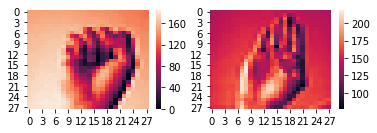

In [15]:
pixels = train_data[20].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = train_data[30].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

In [16]:
reshaped_train = []
for i in train_data:
    reshaped_train.append(i.reshape(1, 28, 28))
train_data = np.array(reshaped_train)

reshaped_test = []
for i in test_data:
    reshaped_test.append(i.reshape(1, 28, 28))
test_data = np.array(reshaped_train)

In [17]:
train_x = torch.FloatTensor(train_data)
train_y = torch.LongTensor(train_labels.tolist())

test_x = torch.FloatTensor(train_data)
test_y = torch.LongTensor(train_labels.tolist())

In [ ]:
class Network():
    def __init__(self):
        